In [19]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
import DCTools as DCTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

import lsst.daf.base as dafBase

import lsst.afw.math as afwMath

import glob
from astropy.io import ascii

from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask

import lsst.daf.base as dafBase
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import CatalogCalculationTask

from lsst.afw.fits import FitsError

from astropy.table import Column

In [2]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Production"
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_daytest/"

directory = DATADIR+"/detect_prod/"
butler = dafPersist.Butler(directory) 


In [29]:
def detect_sources(diffExp, threshold):
    
        algMetadata = dafBase.PropertyList()
        schema = afwTable.SourceTable.makeMinimalSchema()
        dipoleMeasurement = DipoleMeasurementTask

        config = dipoleMeasurement.ConfigClass()
        sigma = threshold
        dipoleMeasurement = dipoleMeasurement(schema, algMetadata=algMetadata)

        source_catalog = None
        classification = []

        #diffExp = sensorRef.get("dayDiff_differenceExp")

        print sigma
        results = DSTools.detect_diasources(diffExp, doSmooth=True, threshold=sigma)
        try:
            diaSources =  DCTools.merge_sources(results, schema, algMetadata)
            dipoleMeasurement.run(diaSources, diffExp)
            #print len(diaSources)
            #print source_catalog
            source_catalog = DCTools.remove_nan_sources(diaSources)
            #print len(source_catalog)
        except Exception, e:
             print "exception"
                
        if source_catalog is None:
           # classification =  [str(visit)+"-"+str(ccd)]
           classification = [None]


        return source_catalog

In [33]:
sc = detect_sources(dexp, 20)
print len(sc)

20
46


In [31]:
sc[0]

In [4]:
def get_threshold(dayDiff, factor):
    mi = dayDiff.getMaskedImage()
    bad = dayDiff.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(bad)
    stats = afwMath.makeStatistics(mi, afwMath.STDEVCLIP, sctrl)
    thres = (stats.getValue(afwMath.STDEVCLIP) * factor)
    return thres

In [5]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()


In [6]:
diffexps = []
dayCoadds = []

for patch in patches: 
    if butler.datasetExists("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2004-04-22'}):
        diffexps.append(butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2004-04-22'}))
        dayCoadds.append(butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2004-04-22'}))

In [352]:
diff = []
for dexp in diffexps:
    t1 = get_threshold(dexp, 5)
    array = dexp.getMaskedImage().getImage().getArray().flatten()
    
    non_nan = np.isnan(array)
    array[non_nan] = 0
    
    bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE'])
    mask =  dexp.getMaskedImage().getMask().getArray().flatten()
    #marray = dexp.getMaskedImage().getImage().getArray().copy().flatten()
    
    marray = np.array(array)
    #marray = marray[mask.flatten()&bad_flags == 0]
    marray[mask.flatten()&bad_flags!=0]=0
    t2 = np.std(marray)*5

    diff.append(t1-t2)


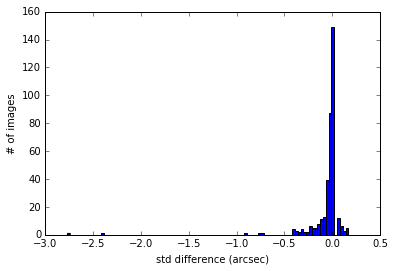

In [354]:
plt.hist(diff, bins=100)
plt.xlabel("std difference (arcsec)")
plt.ylabel("# of images")
plt.show()

In [159]:
dexp = diffexps[50]
array = dexp.getMaskedImage().getImage().getArray().flatten()
bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
mask =  dexp.getMaskedImage().getMask().getArray().flatten()
print array[(716*1200)+628]
print mask[(716*1200)+628]
bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
print bad_flags&0

-0.0719765
0
0


In [15]:
m = dexp.getMaskedImage().getMask()
m.getMaskPlaneDict()

{u'BAD': 0L,
 u'CLIPPED': 9L,
 u'CR': 3L,
 u'DETECTED': 5L,
 u'DETECTED_NEGATIVE': 6L,
 u'EDGE': 4L,
 u'INTRP': 2L,
 u'NOT_DEBLENDED': 10L,
 u'NO_DATA': 8L,
 u'SAT': 1L,
 u'SUSPECT': 7L,
 u'UNMASKEDNAN': 11L}

In [153]:
array = dexp.getMaskedImage().getImage().getArray()
array[716][628]


-0.071976483

In [17]:
bad_flags

371L

In [18]:
test = np.array(array.copy())

test=[1,2,3,4,5,6,7,8,9, 275]
test = np.array(test)
res = test[test&bad_flags==0]

print test, bad_flags

print res

test[test&bad_flags!=0] = 0
print test

[  1   2   3   4   5   6   7   8   9 275] 371
[4 8]
[0 0 0 4 0 0 0 8 0 0]


In [24]:
array
marray = np.array(array)
marray = marray[mask.flatten()&bad_flags!=0]
print len(marray), len(array)

883407 1440000


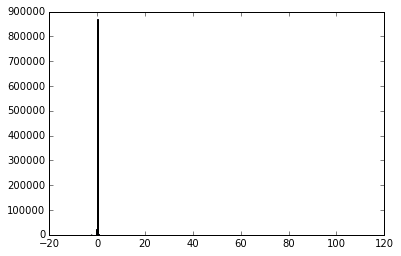

In [25]:
plt.hist(array.flatten(), bins=500)
plt.show()

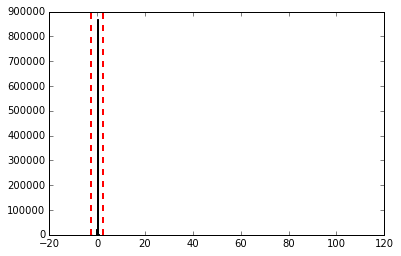

In [26]:
sigma_5 = array.std()*5
plt.hist(array.flatten(), bins=500)

plt.axvline(sigma_5, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-sigma_5, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [140]:
dexp = diffexps[50]
s_cat = detect_sources(dexp)

In [141]:

bad_flags3 = dexp.getMaskedImage().getMask().getPlaneBitMask(['DETECTED', 'DETECTED_NEGATIVE'])


In [188]:
array = dexp.getMaskedImage().getImage().getArray().flatten()
mask =  dexp.getMaskedImage().getMask().getArray().flatten()
marray = np.array(array)
marray = marray[mask.flatten()&bad_flags!=0]
print len(marray), len(array)

510294 1440000


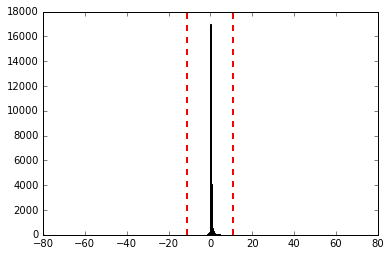

2.19651
10.9825658798


In [145]:
sigma_5 = marray.std()*5
plt.hist(marray.flatten(), bins=500)

plt.axvline(sigma_5, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-sigma_5, color='r', linestyle='dashed', linewidth=2)
plt.show()
print marray.std()
print sigma_5

In [127]:
psf = dexp.getPsf()
shape = psf.computeShape()
sigma = shape.getDeterminantRadius()
print sigma

2.21777045294


In [304]:
mi = dexp.getMaskedImage()
i = mi.getImage()


In [128]:
sigma_v = marray.std()

In [129]:
(sigma_v-sigma)/sigma

0.34609839960181066

In [356]:
bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
bad_flags2 = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE'])

In [44]:
cal_stds = []
cont_stds = []
diff= []
factor = 20
for dexp in diffexps:
    detect_sources(dexp, factor)
    t1 = get_threshold(dexp,factor)
    cont_stds.append(t1)
    
    array = dexp.getMaskedImage().getImage().getArray().flatten()
    non_nan = np.isnan(array)
    array[non_nan] = 0
    bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE'])
    #bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA'])
    mask =  dexp.getMaskedImage().getMask().getArray().flatten()
    
    marray = np.array(array)
   
    marray = marray[mask.flatten()&bad_flags == 0]
    
    #marray[mask.flatten()&bad_flags!=0]=0
    t2 = np.std(marray)*factor
    cal_stds.append(t2)
    diff.append(t1-t2)
    


20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

In [45]:
print t1, t2

1.92175562414 2.01698675752


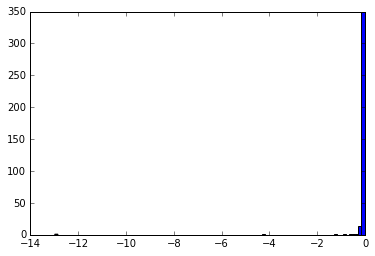

In [46]:
plt.hist(diff, bins=100)
plt.show()

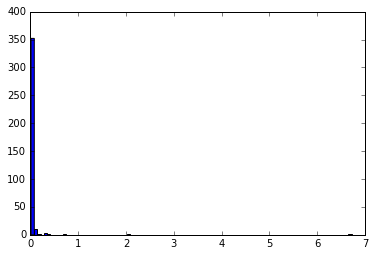

In [48]:
diff_stds = [(a-b)/b for a,b in zip(cal_stds, cont_stds)]
plt.hist(diff_stds, bins=100)
plt.show()

In [348]:
cal_stds

[0.54292149841785431,
 0.59066072106361389,
 0.92550277709960938,
 0.57043995708227158,
 0.53510744124650955,
 0.70407666265964508,
 0.55886831134557724,
 0.51961179822683334,
 0.79588249325752258,
 0.61770997941493988,
 0.54042581468820572,
 0.55952396243810654,
 0.50899889320135117,
 0.43072666972875595,
 0.41555747389793396,
 0.41603077203035355,
 0.71465499699115753,
 0.52395429462194443,
 0.42724084109067917,
 0.40916368365287781,
 0.40834434330463409,
 0.41788909584283829,
 0.41414812207221985,
 0.43015841394662857,
 0.4477793350815773,
 0.41687648743391037,
 0.46358563005924225,
 0.51616698503494263,
 0.4108000174164772,
 0.42683519423007965,
 0.41403234004974365,
 0.45094400644302368,
 0.44871658086776733,
 0.42495522648096085,
 0.42767021805047989,
 0.59030536562204361,
 0.69386638700962067,
 0.47786768525838852,
 0.43220151215791702,
 0.43393626809120178,
 0.42578201740980148,
 0.44433567672967911,
 0.44212829321622849,
 0.43867498636245728,
 0.42776405811309814,
 0.478980988

In [349]:
cont_stds

[0.5125699404671628,
 0.5452488366992975,
 0.5802549019813392,
 0.48764297306816506,
 0.5224246683255664,
 0.6807742708497143,
 0.5332719997789781,
 0.48628696173119906,
 0.5462562255217428,
 0.503352928975076,
 0.5034848434123016,
 0.4808151370178133,
 0.4851006348486772,
 0.4203554427242333,
 0.406054674901812,
 0.40533246620262486,
 0.4291451912664691,
 0.5075673843925143,
 0.41671764187259513,
 0.402012889270914,
 0.4013824258666435,
 0.40617365656088944,
 0.40580510381894364,
 0.40202126751741984,
 0.4051607548739194,
 0.40329089599280554,
 0.413125849470919,
 0.49253149123393225,
 0.4037194087990622,
 0.3964053376011411,
 0.4069219656654214,
 0.43833151666163805,
 0.43418938503238313,
 0.4175217128006606,
 0.4179761653178671,
 0.42821243803641984,
 0.5269604614669633,
 0.438945374061625,
 0.4183444992888222,
 0.42551552074622745,
 0.41659108875739326,
 0.42727662338895134,
 0.4163566533421658,
 0.4134537268596059,
 0.41059292287588095,
 0.43182592304601536,
 0.5102756620369133,
 